In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
def init_board_gauss(N, k):
    ''' taken from https://datasciencelab.wordpress.com/tag/lloyds-algorithm/
    used to intialze the data set with k clusters and N points
    '''
    n = float(N)/k
    X = []
    for i in range(k):
        c = (random.uniform(-10, 10), random.uniform(-10, 10))
        s = random.uniform(0.05,0.5)
        x = []
        while len(x) < n:
            a, b = np.array([np.random.normal(c[0], s), np.random.normal(c[1], s)])       
            x.append([a,b])
        X.extend(x)
    X = np.array(X)[:N]
    return X

(2, 2)


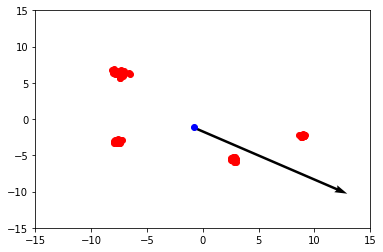

In [3]:
def scope():
    '''
    demo of PCA 
    In algorithm the each area is split based on the eigen vector that corresponds to max eigen value
    for no numpy implementation a library with eigen value computation is required
    this is linear in data points
    '''
    data_fit =  init_board_gauss(100,4).transpose()
    mean_x = data_fit[0].mean()
    mean_y = data_fit[1].mean()
    diff_x = mean_x - data_fit[0];
    diff_y = mean_y - data_fit[1];
    diff = np.array([diff_x, diff_y])
    cov_mat = np.matmul(diff,diff.transpose()) 
    # dimentions of this matrix does not depend on data size but on point dimentions 
    # 2,2 in case of a plane
    eig_val, eig_vec=np.linalg.eig(cov_mat)  
    print(cov_mat.shape)
    #print(eig_val)
    #print(eig_vec)
    index = np.argmax(eig_val)
    plt.plot(data_fit[0],data_fit[1],'ro')
    plt.plot(mean_x, mean_y,'bo')
    
    plt.quiver(mean_x, mean_y,eig_vec[0,index],eig_vec[1,index], scale=2)
    plt.axis([-15, 15, -15, 15])
scope()

In [29]:
# define data struct  needed to store the processed map

class MapNode(object):
    '''  node in the map tree'''
    def __init__(self, x, y, eig_vec, num_points, rmse):
        self.left=None
        self.right=None
        self.x = x
        self.y = y
        self.eig_vec = eig_vec
        self.num_points = num_points
        self.rmse = rmse
class Point(object):
    ''' leaf in the map tree'''
    def __init__(self, x, y):
        self.x = x
        self.y = y

def parse_map(data_fit):
    ''' basic implementaion of k-mean tree with PCA rotations at every  split
    used to avoid grid effect when visualizing n-th slice of the map tree
    '''
    _, num_points = data_fit.shape
    #print(data_fit.shape)
    if num_points == 0:
        #print('terminated',depth)
        return None
    if num_points == 1:
        #print("term",depth)
        return Point(data_fit[0],data_fit[1])
    #print("con",depth)
    mean_x = data_fit[0].mean()
    mean_y = data_fit[1].mean()
    diff_x = mean_x - data_fit[0];
    diff_y = mean_y - data_fit[1];
    diff = np.array([diff_x, diff_y])
    cov_mat = np.matmul(diff,diff.transpose())
    eig_val, eig_vec = np.linalg.eig(cov_mat)
    index = np.argmax(eig_val)
    rsme = np.sqrt(np.matmul(diff_x,diff_x) + np.matmul(diff_y,diff_y))
    new_node = MapNode(mean_x, mean_y, eig_vec[:,index], num_points, rsme)
    sort_val  = np.matmul(new_node.eig_vec, diff)
    
    #this recursive (naive) can bi unwinded
    new_node.left = parse_map(data_fit[:,np.where(sort_val>0)[0]])
    new_node.right = parse_map(data_fit[:,np.where(sort_val<=0)[0]])
    #TODO partion data
    return new_node

def get_forest(map_node, number):
    ''' return top n clusters'''
    if type(map_node) is not MapNode:
        return map_node
    forest = [map_node]
    leafs = []
    #this check can be replaced by the distance to open nodes
    # that would prabably fit the application better
    while len(forest) + len(leafs) < number and len(forest)!=0:
        sorted(forest, key=lambda node: node.rmse/node.num_points)
        node = forest.pop(0)
        
        #this naive
        if type(node.left) is MapNode:
            forest.append(node.left)
        if type(node.right) is MapNode:   
            forest.append(node.right)
        if type(node.left) is Point:
            leafs.append(node.left)
        if type(node.right) is Point:   
            leafs.append(node.right)

    return forest+leafs
    


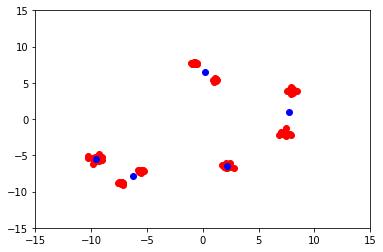

In [37]:
def scope():
    # static show case
    data_fit =  init_board_gauss(100,8).transpose()
    map_node = parse_map(data_fit)
    
    plt.plot(data_fit[0],data_fit[1],'ro')
    nodes = get_forest(map_node,5)
    for node in nodes:
        plt.plot(node.x, node.y,'bo')
    
    plt.axis([-15, 15, -15, 15])
scope()

In [38]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Dynamic show case

In [39]:

class Vitest(object):
    def __init__(self,points,clusters):
        self.data_fit = init_board_gauss(points,clusters).transpose()
        self.map_node = parse_map(self.data_fit)
    def inertscope(self,n):
        plt.plot(self.data_fit[0],self.data_fit[1],'ro')
        nodes = get_forest(self.map_node,n)
        for node in nodes:
            plt.plot(node.x, node.y,'bo')

        plt.axis([-15, 15, -15, 15])

In [40]:
# noticalbe slowdown when dragging slided due to re drawing of every point on the image for every step of the slider
#that is not optimal 
tester=Vitest(200, 10)
interact(tester.inertscope, n=widgets.IntSlider(min=1,max=50,step=1,value=10))

interactive(children=(IntSlider(value=10, description='n', max=50, min=1), Output()), _dom_classes=('widget-in…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>